# Ideal Parameter Analysis ($\delta=1.5$, $\tau=1.25$, $\alpha=2$) ($\delta$ step down)

In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import sys

from datetime import datetime

sys.path.append('../../feeg_fmri_sync')

from feeg_fmri_sync.plotting import (
    plot_all_search_results_2d,
    plot_local_minima
)
from feeg_fmri_sync.search import (
    build_models,
    search_voxels
)
from feeg_fmri_sync.simulations import (
    build_model_to_fmri,
    generate_downsampled_simulated_fmri,
)
from feeg_fmri_sync.utils import (
    generate_descriptions_from_search_df,
)
from feeg_fmri_sync.vectorized_models import VectorizedHemodynamicModel

In [2]:
try_to_reuse = True
submit_to_cluster = False

## Initialize constants for Hemodynamic Modeling

In [3]:
### Initialize constants ###
sample_freq = 20
tr = 800
n_trs_skipped_at_beginning = 0
hemodynamic_response_window = 30

# Actual Values to generate data from
expected_delta = 1.5
expected_tau=1.25
expected_alpha=2

## Initialize constants for simulation

In [4]:
# Plot the generated data
# NOTE: only the first of the trials will be plotted
plot_generated_data = True

# Plot perfect data when modeling
plot_perfect_comparison = True

# noises to examine and plot when modeling
noise_range = range(1, 11)  
noises_to_plot = [3, 5, 10]

# trials we run for each condition and how many trials to plot when modeling
num_trials = 100  
num_trials_to_plot = 1

# models to examine
models_to_test = [
    {
        'name': 'downsample',
        'model': VectorizedHemodynamicModel,
        'fmri_data_generator': generate_downsampled_simulated_fmri,
    }
]

# eeg data types to use
eeg_data_options_for_fmri_generation = ['without_nans']
eeg_data_options_for_simulation = ['without_nans', 'with_nans']

## Display Generated Noise against Simulated Ground Truth

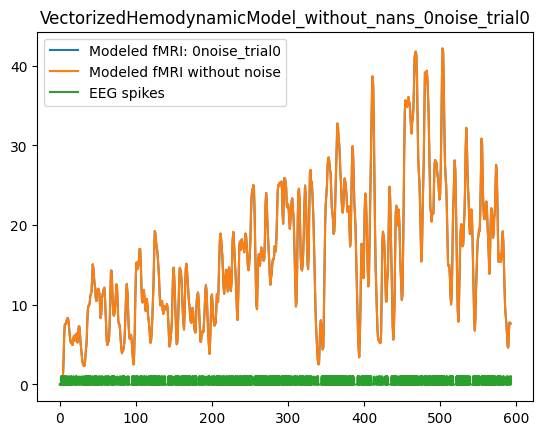

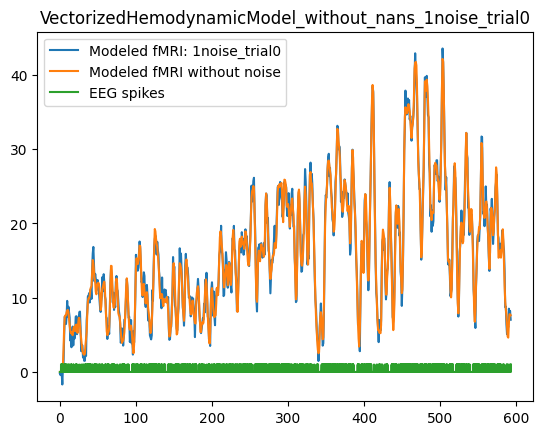

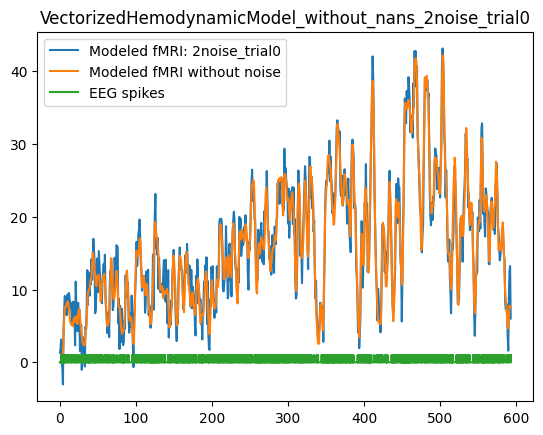

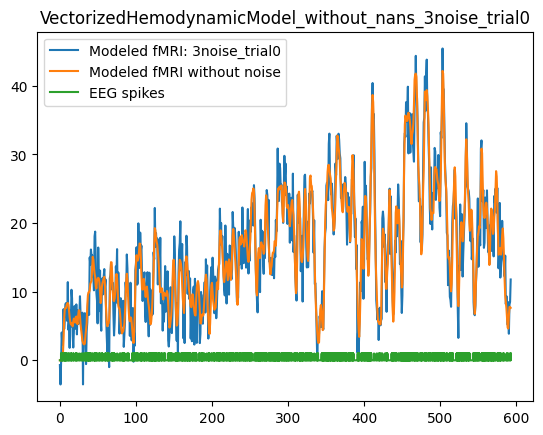

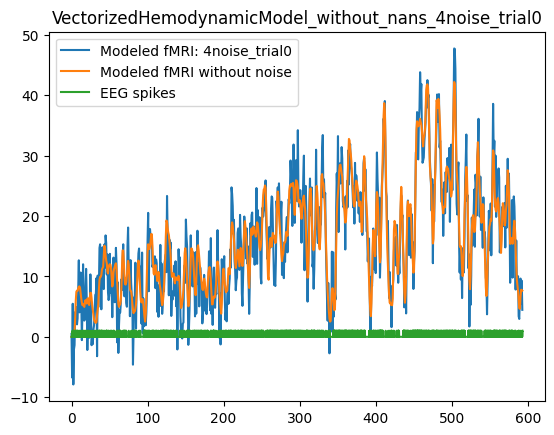

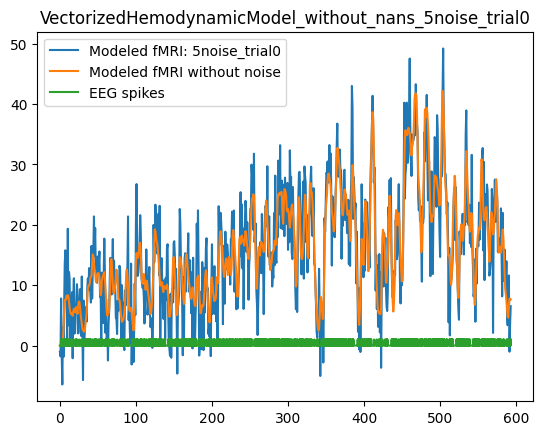

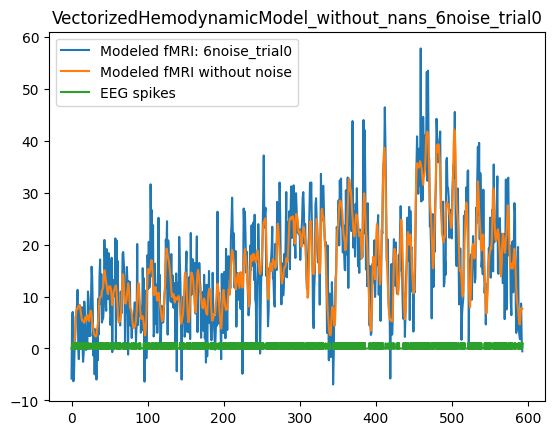

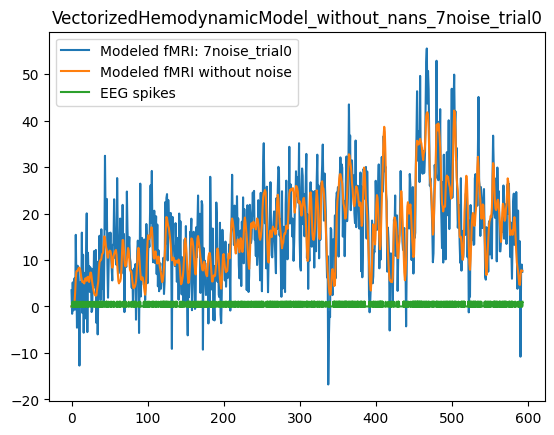

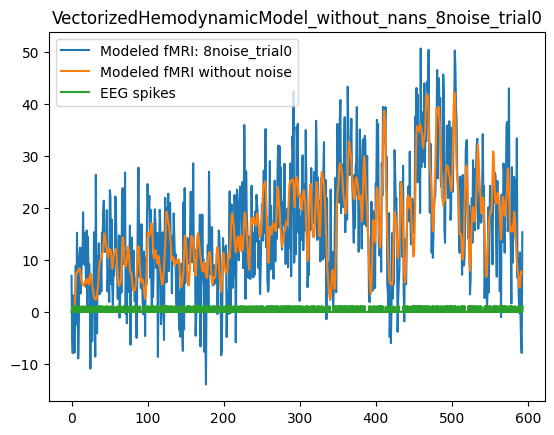

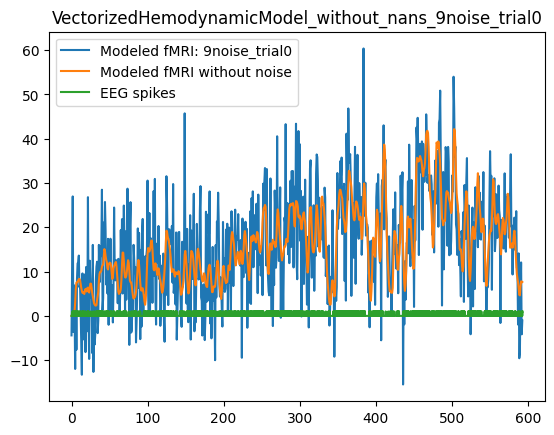

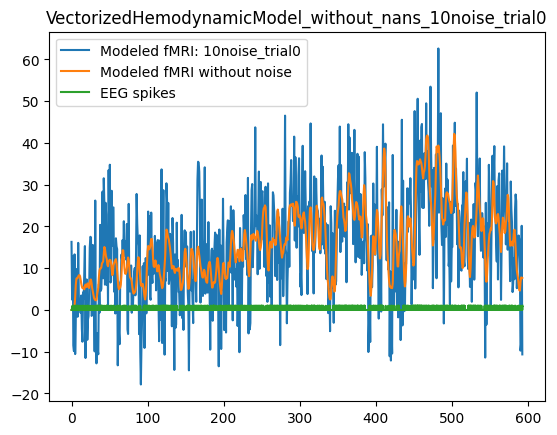

In [5]:
# Generate fMRI data
model_to_fmri = build_model_to_fmri(
    models_to_test,
    eeg_data_options_for_fmri_generation,
    expected_delta,
    expected_tau,
    expected_alpha,
    num_trials,
    num_trials_to_plot,
    noise_range,
    noises_to_plot,
    plot_perfect_comparison,
    tr,
    sample_freq,
    hemodynamic_response_window,
    plot_generated_data
)


## Initialize Analysis variables

In [6]:
step_size = 0.05

filename_substring = f'effect_of_ideal_params_delta{expected_delta}_tau{expected_tau}_alpha{expected_alpha}'
filename_ext = '.csv'
plot = True

delta = np.arange(1, 3+step_size, step_size)
tau = np.arange(0.75, 1.75+step_size, step_size)
alpha = np.arange(1.75, 2.25+step_size, step_size)

print(f'Delta target: {expected_delta}, Range:\n{delta}\n')
print(f'Tau target: {expected_tau}, Range:\n{tau}\n')
print(f'Alpha target: {expected_alpha}, Range:\n{alpha}\n')

Delta target: 1.5, Range:
[1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35 1.4  1.45 1.5  1.55 1.6  1.65
 1.7  1.75 1.8  1.85 1.9  1.95 2.   2.05 2.1  2.15 2.2  2.25 2.3  2.35
 2.4  2.45 2.5  2.55 2.6  2.65 2.7  2.75 2.8  2.85 2.9  2.95 3.  ]

Tau target: 1.25, Range:
[0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35 1.4
 1.45 1.5  1.55 1.6  1.65 1.7  1.75]

Alpha target: 2, Range:
[1.75 1.8  1.85 1.9  1.95 2.   2.05 2.1  2.15 2.2  2.25]



## Est vs Actual for all models at correct points

Scoring downsample_without_nans_without_nans delta=1.5, tau=1.25, alpha=2


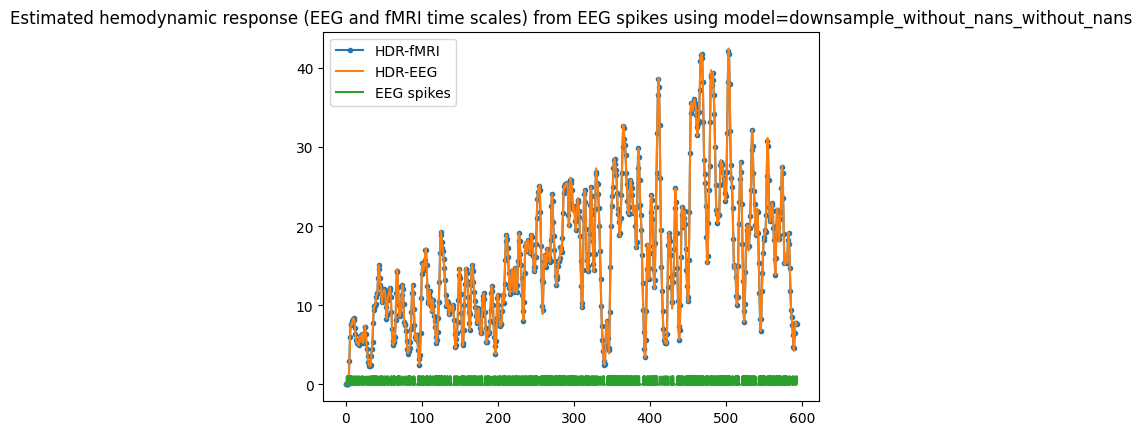

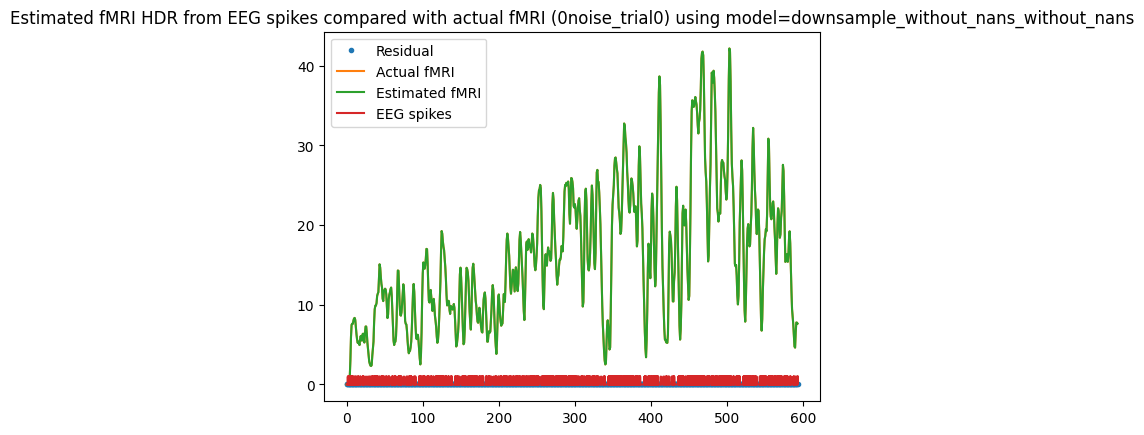

Residual Variance is 0.000000


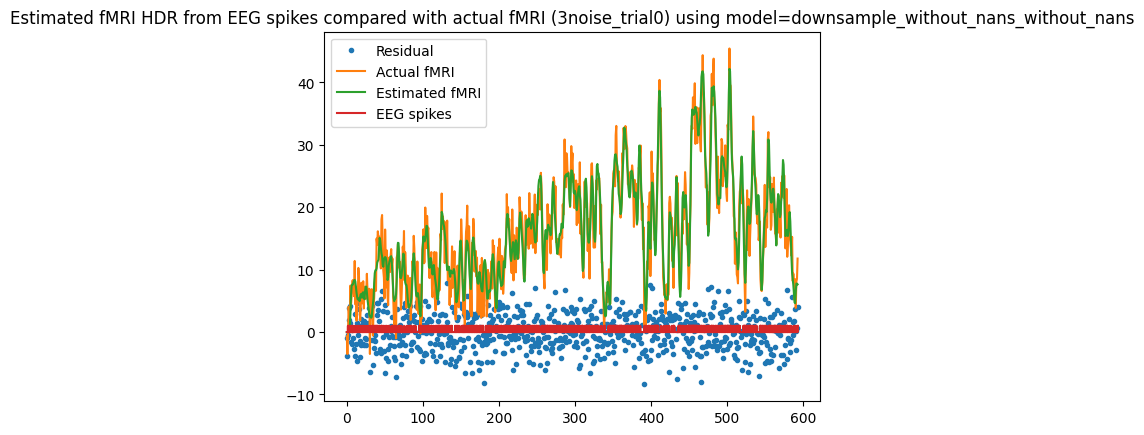

Residual Variance is 8.625622


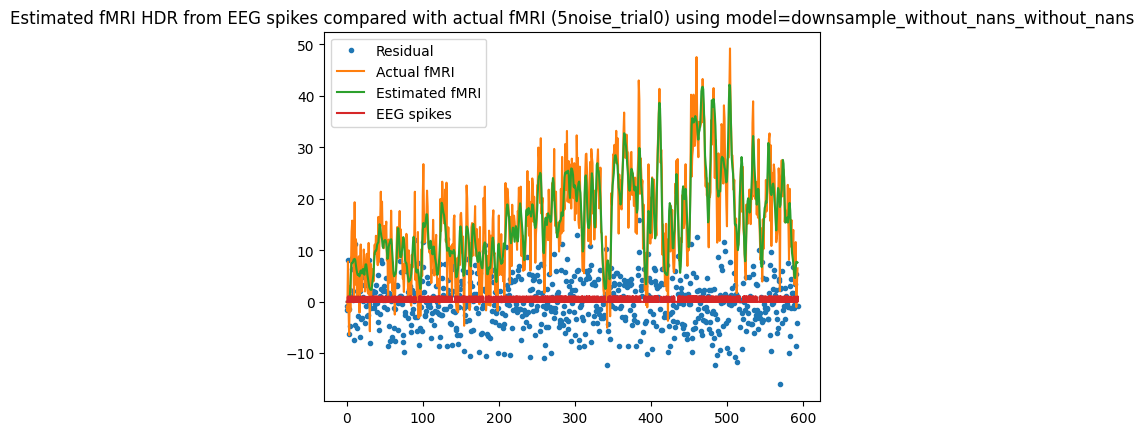

Residual Variance is 22.940712


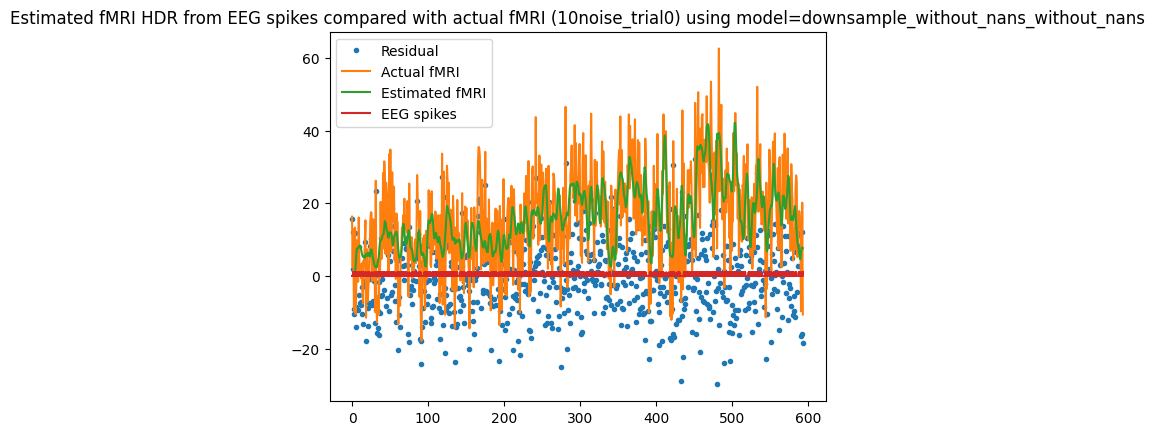

Residual Variance is 105.519782


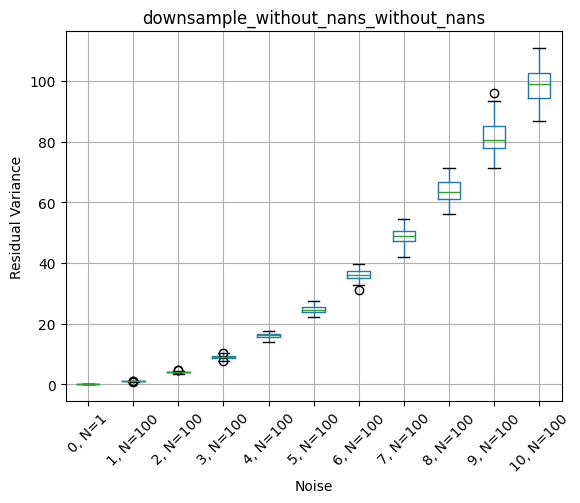

Scoring downsample_without_nans_with_nans delta=1.5, tau=1.25, alpha=2


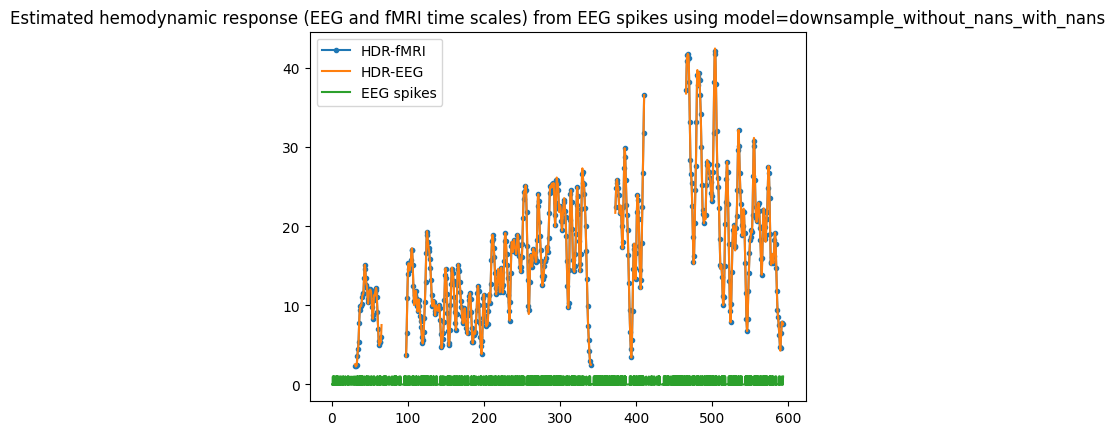

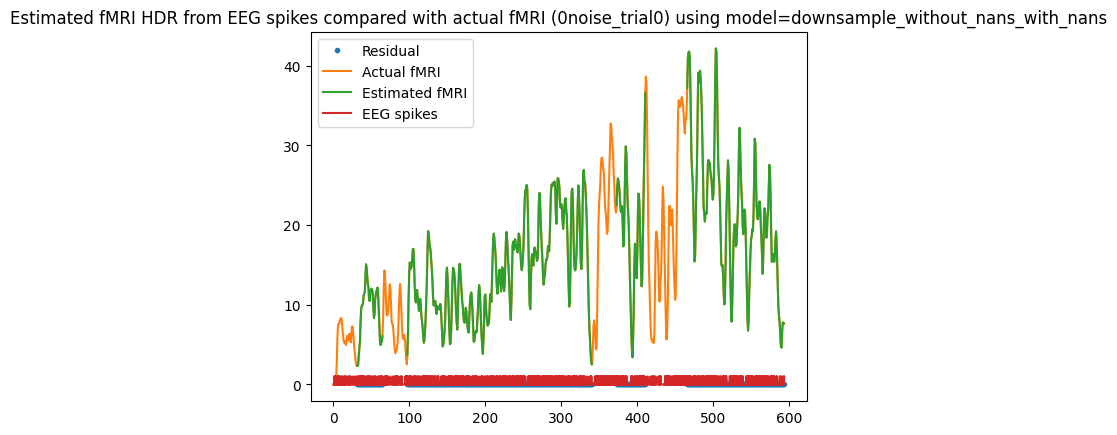

Residual Variance is 0.000000


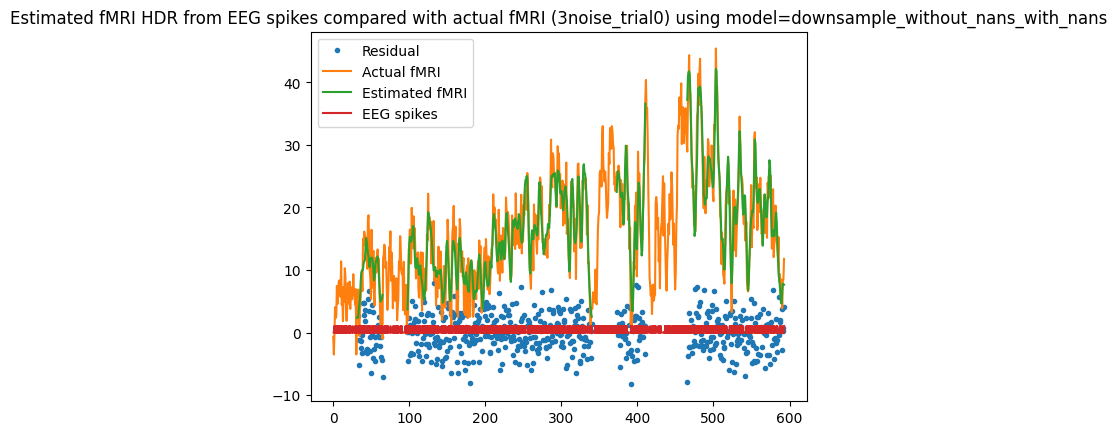

Residual Variance is 9.129408


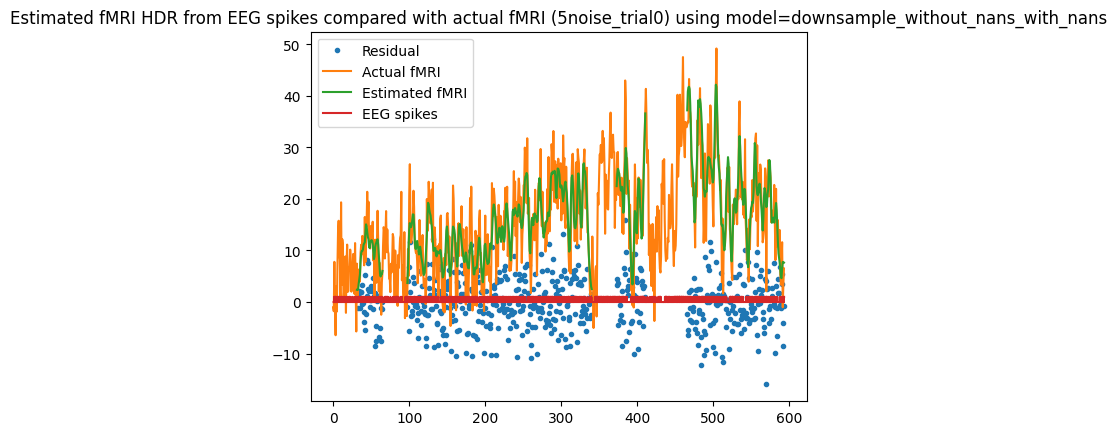

Residual Variance is 22.974836


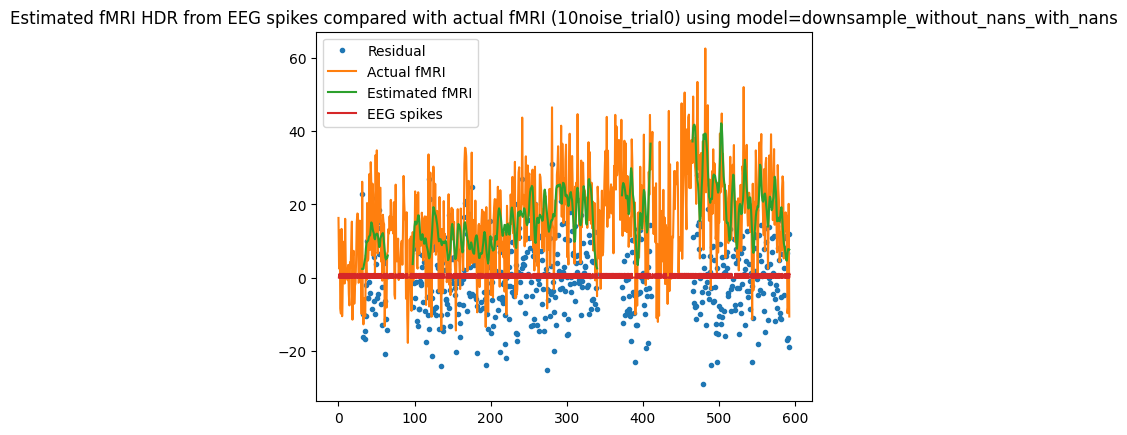

Residual Variance is 104.829694


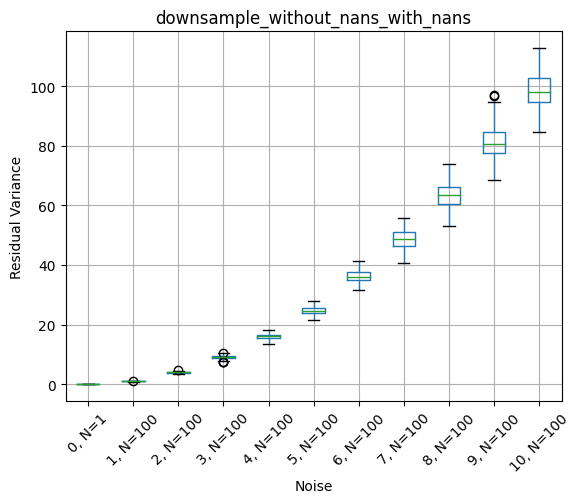

In [7]:
models = build_models(
    model_to_fmri,
    eeg_data_options_for_simulation,
    tr, 
    n_trs_skipped_at_beginning,
    sample_freq,
    hemodynamic_response_window,
    plot
)

# Get in-depth plots for actual delta, tau, alpha
for model_name, model in models.items():
    residual_var = model.score(expected_delta, expected_tau, expected_alpha)
    fmri_names = np.array(model.fmri.voxel_names)
    if (fmri_names == None).any():
        print(f'Residual variance was {residual_var}')
    else:
        noise_levels = np.char.replace(fmri_names, 'perfect', '0noise_trail0')
        noise_levels = np.char.partition(noise_levels, sep='noise')
        res_var_df = pd.DataFrame(zip(noise_levels[:,0].astype(int), residual_var), columns=['Noise', 'res_var'])
        res_var_by_noise = res_var_df.groupby('Noise')
        _, axs = plt.subplots()
        axs.set_title(model_name)
        axs.set_ylabel('Residual Variance')
        axs.set_xlabel('Noise')
        axs = res_var_by_noise.boxplot(column='res_var', subplots=False, rot=45, ax=axs)
        labels = res_var_by_noise.count()
        labels = [f'{noise}, N={n.item()}' for noise, n in zip(labels.index, labels.values)]
        plt.setp(axs, xticklabels=labels)
        plt.show()
    model.plot = False

## Generate/Load the full dataset

In [8]:
# Optional Reuse functionality

df = pd.DataFrame()
descriptions = []

if try_to_reuse:
    matching_files = sorted(glob.glob(f'{filename_substring}*{filename_ext}'))
    filename_to_use = "none"
    if len(matching_files) != 0:
        filename_to_use = input(
            f'Found previously run data. Enter name to reuse or "none" to recalculate.'
            f'\n{matching_files}\nDefault ({matching_files[-1]})\n'
        )
    if filename_to_use.lower() != "none":
        if filename_to_use.strip() == '':
            filename_to_use = matching_files[-1]
        print(f'Loading data from {filename_to_use}...')
        with open(filename_to_use, 'r') as f:
            df = pd.read_csv(f, index_col=0)
        descriptions = generate_descriptions_from_search_df(df, models)


In [9]:
if df.empty:
    if submit_to_cluster:
        raise NotImplemented("Submitting to the cluster is not implemented!")
    print('Generating data!')
    descriptions, df = search_voxels(models, delta, tau, alpha)
    with open(f'{filename_substring}_{datetime.now().strftime("%Y-%m-%d_%H:%M")}{filename_ext}', 'w') as f:
        pd.DataFrame(df).to_csv(f)
    for model_name, description in zip(models.keys(), descriptions):
        with open(f'{model_name}_summary_{filename_substring}_{datetime.now().strftime("%Y-%m-%d_%H:%M")}{filename_ext}', 'w') as f:
            pd.DataFrame(description).transpose().to_csv(f)

df

Generating data!
Scoring delta=1.0
Scoring delta=1.05
Scoring delta=1.1
Scoring delta=1.1500000000000001
Scoring delta=1.2000000000000002
Scoring delta=1.2500000000000002
Scoring delta=1.3000000000000003
Scoring delta=1.3500000000000003
Scoring delta=1.4000000000000004
Scoring delta=1.4500000000000004
Scoring delta=1.5000000000000004
Scoring delta=1.5500000000000005
Scoring delta=1.6000000000000005
Scoring delta=1.6500000000000006
Scoring delta=1.7000000000000006
Scoring delta=1.7500000000000007
Scoring delta=1.8000000000000007
Scoring delta=1.8500000000000008
Scoring delta=1.9000000000000008
Scoring delta=1.9500000000000008
Scoring delta=2.000000000000001
Scoring delta=2.0500000000000007
Scoring delta=2.100000000000001
Scoring delta=2.1500000000000012
Scoring delta=2.200000000000001
Scoring delta=2.250000000000001
Scoring delta=2.300000000000001
Scoring delta=2.3500000000000014
Scoring delta=2.4000000000000012
Scoring delta=2.450000000000001
Scoring delta=2.5000000000000013
Scoring de

delta                 tau               alpha  \
0                     1.0                0.75                1.75   
1                     1.0                0.75                1.75   
2                     1.0                0.75                 1.8   
3                     1.0                0.75                 1.8   
4                     1.0                0.75                1.85   
...                   ...                 ...                 ...   
18937  3.0000000000000018  1.7500000000000009  2.1500000000000004   
18938  3.0000000000000018  1.7500000000000009                 2.2   
18939  3.0000000000000018  1.7500000000000009                 2.2   
18940  3.0000000000000018  1.7500000000000009  2.2500000000000004   
18941  3.0000000000000018  1.7500000000000009  2.2500000000000004   

                                 model_name       0noise_trial0  \
0      downsample_without_nans_without_nans  27.915943262881342   
1         downsample_without_nans_with_nans   25.87209981400628   
2      downsample_without_nans_without_nans  26.919396985612586   
3         downsample_without_nans_with_nans  24.967603837765836   
4      downsample_without_nans_without_nans  25.931798424279524   
...                                     ...                 ...   
18937     downsample_without_nans_with_nans    22.5179726270642   
18938  downsample_without_nans_without_nans   25.12154502509812   
18939     downsample_without_nans_with_nans   23.11531154653473   
18940  downsample_without_nans_without_nans  25.805748381788636   
18941     downsample_without_nans_with_nans  23.698768632721308   

            1noise_trial0       2noise_trial0       3noise_trial0  \
0      28.376496379859482   31.04395809901957  35.169863274808655   
1      26.311312842509516  28.720077764606813  33.352479860501774   
2        27.3960480013757  30.057174310454542  34.244499850087706   
3       25.42437683860874  27.836904207338396  32.502847933752285   
4      26.424904031479173    29.0797185649181   33.32761153743269   
...                   ...                 ...                 ...   
18937   23.11718163061369  26.597876197786917  31.217898853465613   
18938   25.70314484843783  29.561287455142498  32.579687559790095   
18939  23.696886807085477   27.17974971721793   31.81104198258982   
18940     26.369537147669    30.2317599390795  33.262477207526935   
18941   24.26290059318274  27.747433640033606   32.39132562022267   

            4noise_trial0       5noise_trial0  ...      1noise_trial99  \
0       45.28525590702257    53.0100773727996  ...   28.25294346015835   
1      44.284742060831064   51.06417740536425  ...   26.66591866999877   
2       44.21376823757955   52.02397517187179  ...  27.276576948971297   
3      43.277069057144836     50.176224808699  ...  25.771671524445495   
4       43.15048918427291    51.0426909757206  ...  26.309891130617093   
...                   ...                 ...  ...                 ...   
18937   38.68574188172063  46.313814306795244  ...   22.66155474751859   
18938   39.14568487134135  48.081731521184345  ...  25.380841077569126   
18939   39.33164088653489   46.99565245231544  ...   23.24746380081347   
18940   39.83562686305261   48.82980328261649  ...   26.05081637663643   
18941   39.96240814795058   47.66101032176112  ...   23.82089498211174   

           2noise_trial99      3noise_trial99      4noise_trial99  \
0      33.198006426344975   36.07906836935523   46.69524991754306   
1       31.28442308497378  35.478042733207026   45.14296295291386   
2      32.145827996504075   35.07022176934425  45.649944834676084   
3       30.32031974475117   34.53467651687603   44.15922337079379   
4       31.10419037369534  34.070271229888334   44.61256502770652   
...                   ...                 ...                 ...   
18937  27.077710436919624     31.052458618237   39.47920526374276   
18938  29.483096253331535   33.51101625449215    41.0931522252954   
18939  27.696883043252388  31.625796226657343  

## No Noise Analysis - downsample without missing data

### Cost

Minimal Cost for Average Cost: noise 0 (downsample_without_nans_without_nans) = 2.4107889760677606e-29; at
      delta   tau  alpha
4850    1.5  1.25    2.0


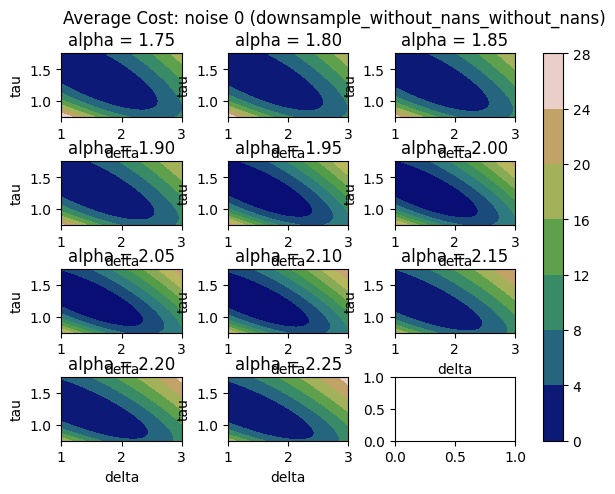

delta   tau  alpha  \
0        1.0  0.75   1.75   
2        1.0  0.75   1.80   
4        1.0  0.75   1.85   
6        1.0  0.75   1.90   
8        1.0  0.75   1.95   
...      ...   ...    ...   
18932    3.0  1.75   2.05   
18934    3.0  1.75   2.10   
18936    3.0  1.75   2.15   
18938    3.0  1.75   2.20   
18940    3.0  1.75   2.25   

       Average Cost: noise 0 (downsample_without_nans_without_nans)  
0                                              27.915943             
2                                              26.919397             
4                                              25.931798             
6                                              24.954125             
8                                              23.987334             
...                                                  ...             
18932                                          22.993729             
18934                                          23.715040             
18936                                          24.424490             
18938                                          25.121545             
18940                                          25.805748             

[9471 rows x 4 columns]

In [10]:
model_name = 'downsample_without_nans_without_nans'
noise = 0
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
columns_for_noise = df_to_plot.columns[columns_to_choose]

average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]

average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
plot_all_search_results_2d(average_df, separate_by='alpha')
average_df


In [11]:
data = []

minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()

for point in zip(*np.where(~np.isnan(minimum_cost_array))):
    row_of_interest = df_to_plot.iloc[point[0]]
    data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha']])
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
pd.DataFrame(data, columns=['delta', 'tau', 'alpha'])

Delta target: 1.5, Tau target: 1.25, Alpha target: 2


delta   tau  alpha
0    1.5  1.25    2.0

### Local Minima Analysis

In [12]:
delta_unique_values = df_to_plot['delta'].unique()    
tau_unique_values = df_to_plot['tau'].unique()
alpha_unique_values = df_to_plot['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(df_to_plot['delta'].values, new_shape)
tau_pts = np.reshape(df_to_plot['tau'].values, new_shape)
alpha_pts = np.reshape(df_to_plot['alpha'].values, new_shape)

# Find local minima
columns = df_to_plot.columns.drop(['delta', 'tau', 'alpha'])

m = np.reshape(
    df_to_plot[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
noise = 0

columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
for point in local_minima_with_given_noise:
    point_as_list = tuple(point.tolist())
    local_minima.append({
        'noise': noise,
        'iteration': columns[point[-1]].split('trial')[-1],
        'cost': m[point_as_list],
        'delta': delta_pts[point_as_list[:-1]],
        'tau': tau_pts[point_as_list[:-1]],
        'alpha': alpha_pts[point_as_list[:-1]]
    })

local_minima_by_noise = pd.DataFrame(local_minima)
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
local_minima_by_noise

Delta target: 1.5, Tau target: 1.25, Alpha target: 2


noise iteration          cost  delta   tau  alpha
0      0         0  3.334448e-03   1.45  1.20   2.15
1      0         0  2.410789e-29   1.50  1.25   2.00
2      0         0  5.312729e-03   1.55  1.30   1.85

In [13]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').mean()

Number of Local Minima
noise                        
0                         3.0

#### Local minima at edges

In [14]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [15]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [16]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [17]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [18]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [19]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

## No Noise Analysis - downsample with missing data

### Cost

Minimal Cost for Average Cost: noise 0 (downsample_without_nans_with_nans) = 1.4160552527771098e-28; at
      delta   tau  alpha
4851    1.5  1.25    2.0


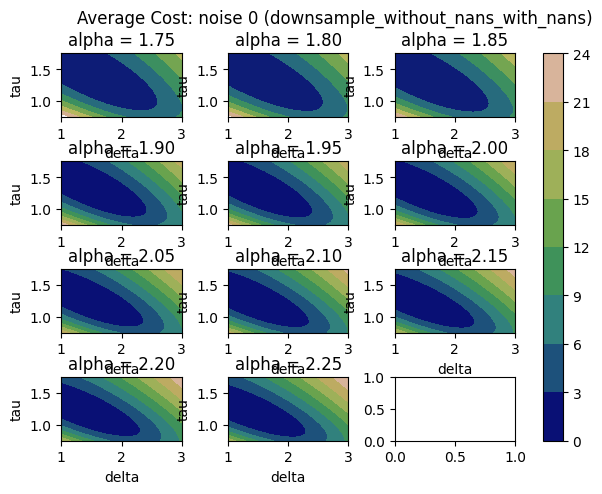

delta   tau  alpha  \
1        1.0  0.75   1.75   
3        1.0  0.75   1.80   
5        1.0  0.75   1.85   
7        1.0  0.75   1.90   
9        1.0  0.75   1.95   
...      ...   ...    ...   
18933    3.0  1.75   2.05   
18935    3.0  1.75   2.10   
18937    3.0  1.75   2.15   
18939    3.0  1.75   2.20   
18941    3.0  1.75   2.25   

       Average Cost: noise 0 (downsample_without_nans_with_nans)  
1                                              25.872100          
3                                              24.967604          
5                                              24.069360          
7                                              23.178312          
9                                              22.295388          
...                                                  ...          
18933                                          21.283021          
18935                                          21.907076          
18937                                          22.517973          
18939                                          23.115312          
18941                                          23.698769          

[9471 rows x 4 columns]

In [20]:
model_name = 'downsample_without_nans_with_nans'
noise = 0
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
columns_for_noise = df_to_plot.columns[columns_to_choose]

average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]

average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
plot_all_search_results_2d(average_df, separate_by='alpha')
average_df


In [21]:
data = []

minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()

for point in zip(*np.where(~np.isnan(minimum_cost_array))):
    row_of_interest = df_to_plot.iloc[point[0]]
    data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha']])
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
pd.DataFrame(data, columns=['delta', 'tau', 'alpha'])

Delta target: 1.5, Tau target: 1.25, Alpha target: 2


delta   tau  alpha
0    1.5  1.25    2.0

### Local Minima Analysis

In [22]:
delta_unique_values = df_to_plot['delta'].unique()    
tau_unique_values = df_to_plot['tau'].unique()
alpha_unique_values = df_to_plot['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(df_to_plot['delta'].values, new_shape)
tau_pts = np.reshape(df_to_plot['tau'].values, new_shape)
alpha_pts = np.reshape(df_to_plot['alpha'].values, new_shape)

# Find local minima
columns = df_to_plot.columns.drop(['delta', 'tau', 'alpha'])

m = np.reshape(
    df_to_plot[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
noise = 0

columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
for point in local_minima_with_given_noise:
    point_as_list = tuple(point.tolist())
    local_minima.append({
        'noise': noise,
        'iteration': columns[point[-1]].split('trial')[-1],
        'cost': m[point_as_list],
        'delta': delta_pts[point_as_list[:-1]],
        'tau': tau_pts[point_as_list[:-1]],
        'alpha': alpha_pts[point_as_list[:-1]]
    })

local_minima_by_noise = pd.DataFrame(local_minima)
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
local_minima_by_noise

Delta target: 1.5, Tau target: 1.25, Alpha target: 2


noise iteration          cost  delta   tau  alpha
0      0         0  3.243826e-03   1.45  1.20   2.15
1      0         0  1.416055e-28   1.50  1.25   2.00
2      0         0  5.306058e-03   1.55  1.30   1.85

In [23]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').mean()

Number of Local Minima
noise                        
0                         3.0

#### Local minima at edges

In [24]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [25]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [26]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [27]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [28]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [29]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

## Cost by Noise

### Downsample without Missing Data

Minimal Cost for Average Cost: noise 1 (downsample_without_nans_without_nans) = 0.9965746109278223; at
      delta   tau  alpha
4850    1.5  1.25    2.0


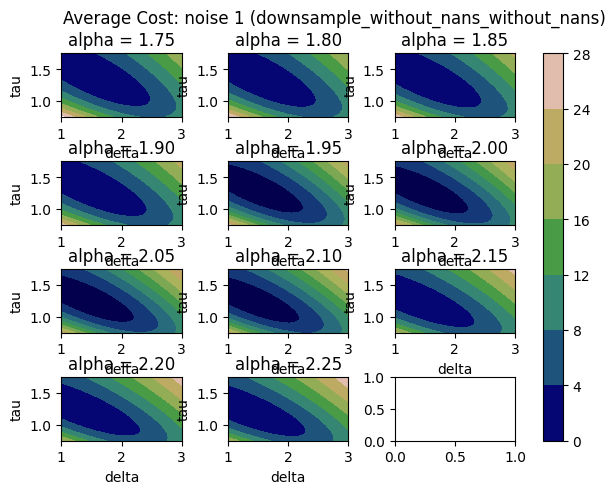

Minimal Cost for Average Cost: noise 2 (downsample_without_nans_without_nans) = 3.9782837286804313; at
      delta   tau  alpha
4850    1.5  1.25    2.0


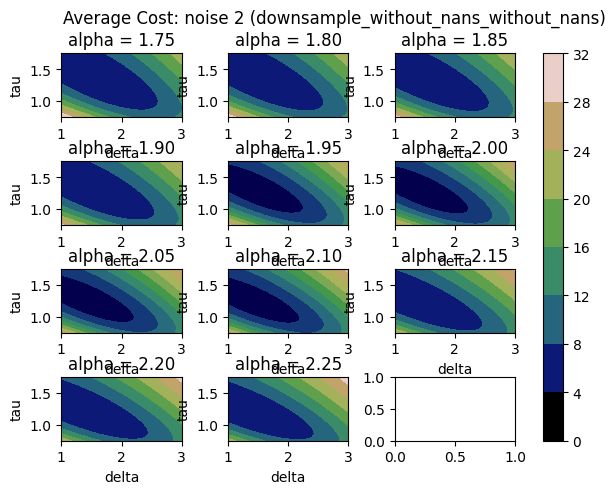

Minimal Cost for Average Cost: noise 3 (downsample_without_nans_without_nans) = 9.009697354635724; at
      delta   tau  alpha
4850    1.5  1.25    2.0


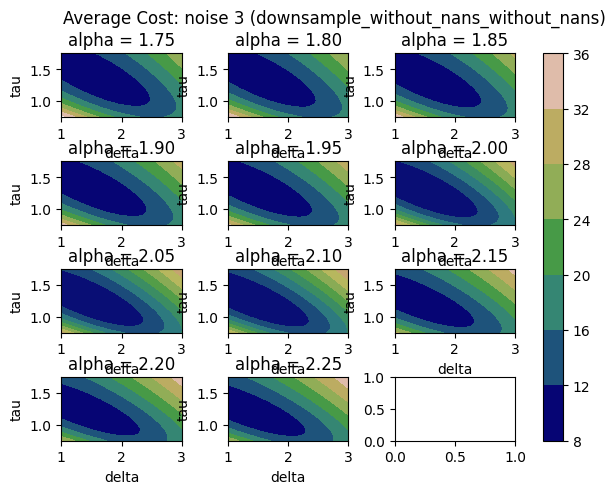

Minimal Cost for Average Cost: noise 4 (downsample_without_nans_without_nans) = 16.012404839679633; at
      delta   tau  alpha
4850    1.5  1.25    2.0


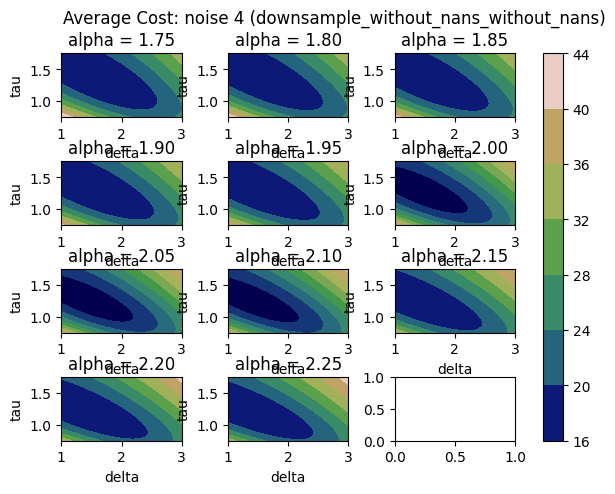

Minimal Cost for Average Cost: noise 5 (downsample_without_nans_without_nans) = 24.71049728001243; at
      delta   tau  alpha
4850    1.5  1.25    2.0


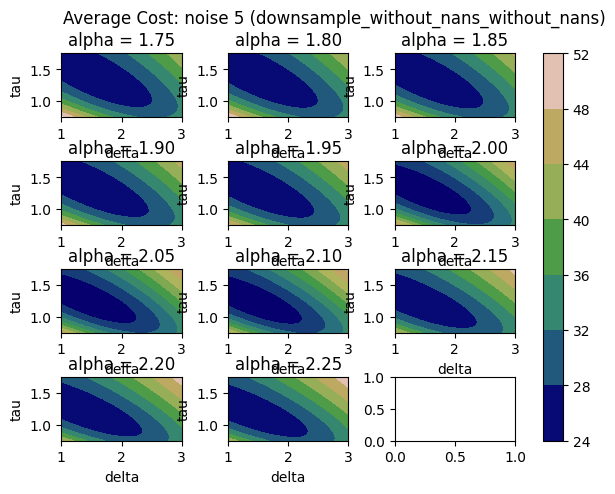

Minimal Cost for Average Cost: noise 6 (downsample_without_nans_without_nans) = 36.1268704142345; at
      delta   tau  alpha
4850    1.5  1.25    2.0


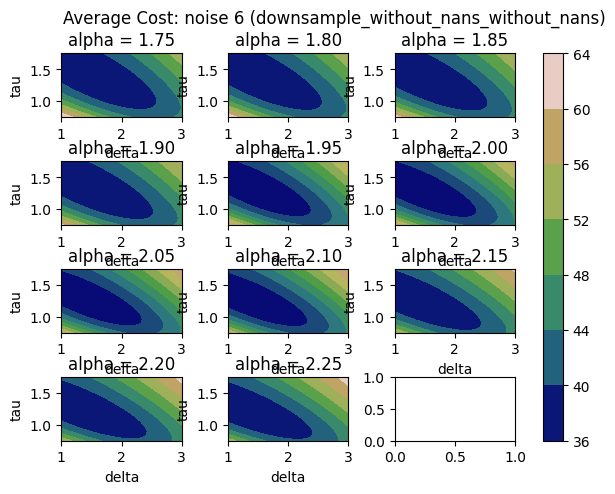

Minimal Cost for Average Cost: noise 7 (downsample_without_nans_without_nans) = 48.77079995166657; at
      delta   tau  alpha
4850    1.5  1.25    2.0


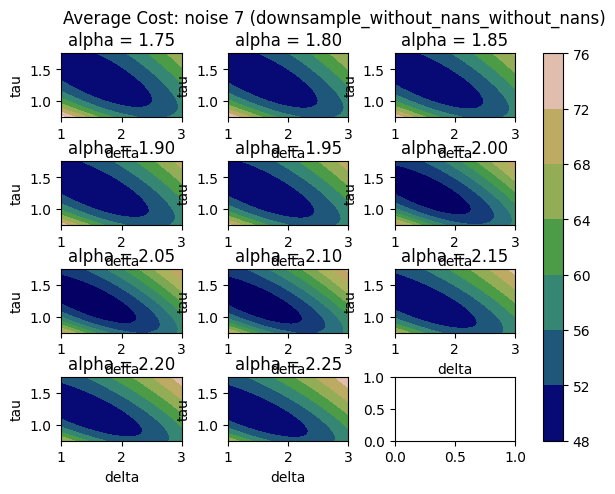

Minimal Cost for Average Cost: noise 8 (downsample_without_nans_without_nans) = 63.71450375829877; at
      delta   tau  alpha
4850    1.5  1.25    2.0


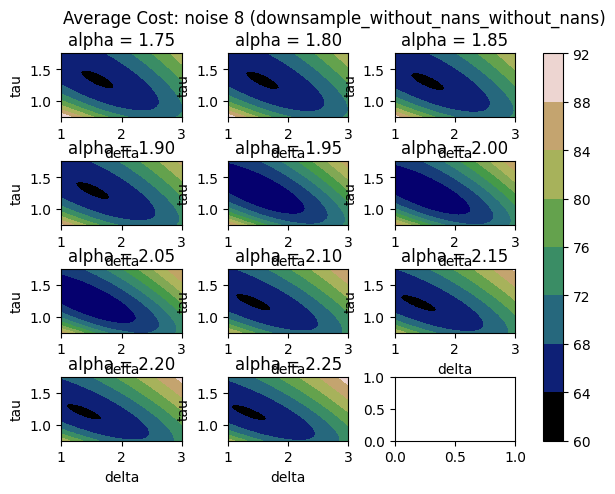

Minimal Cost for Average Cost: noise 9 (downsample_without_nans_without_nans) = 81.32369946785862; at
      delta   tau  alpha
4850    1.5  1.25    2.0


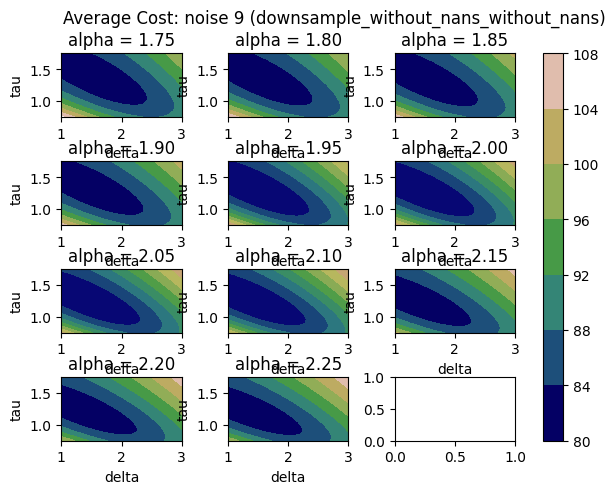

Minimal Cost for Average Cost: noise 10 (downsample_without_nans_without_nans) = 98.72363739519271; at
      delta  tau  alpha
3912    1.4  1.2    2.2


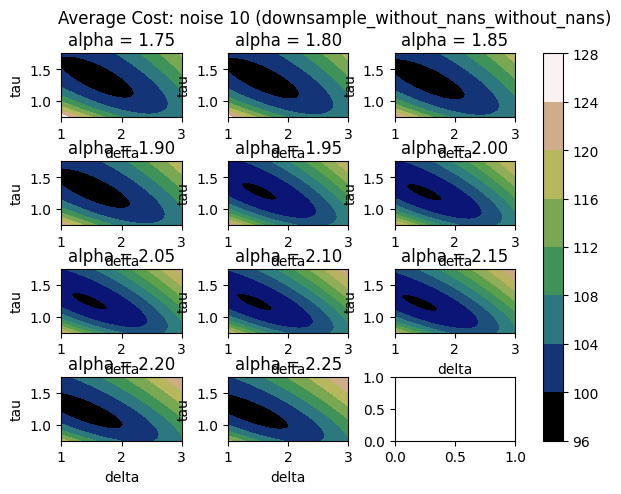

In [30]:
model_name = 'downsample_without_nans_without_nans'
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]

    average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]
    average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
    plot_all_search_results_2d(average_df, separate_by='alpha')

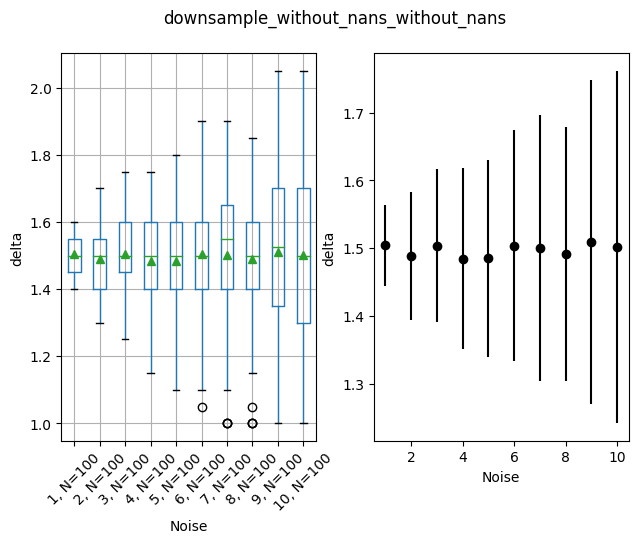

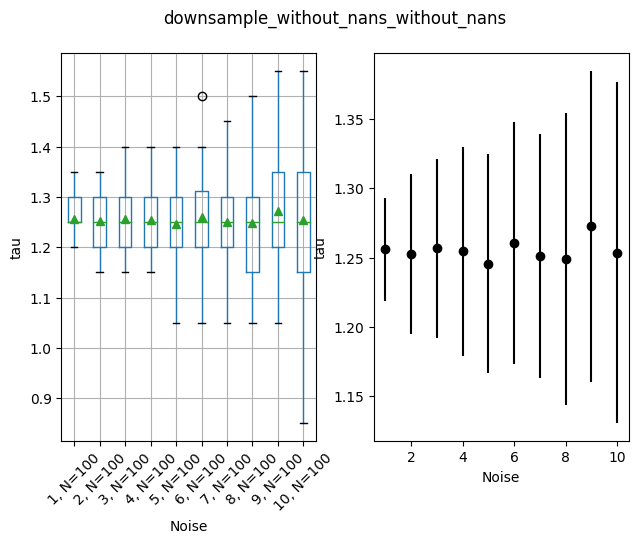

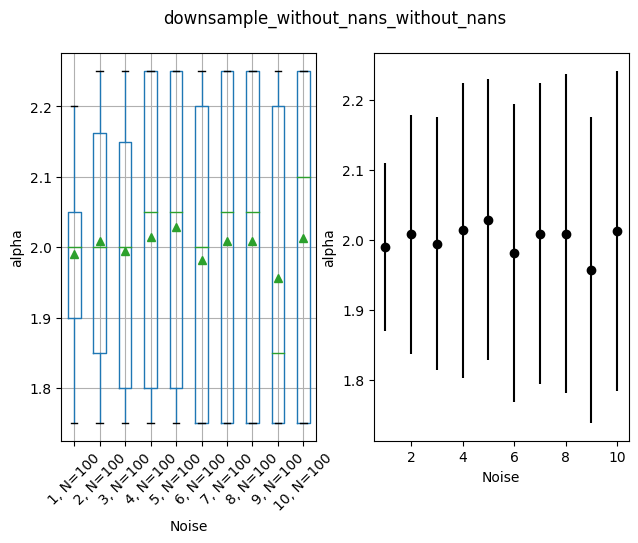

In [31]:
data = []
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]
    minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
    minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()
    
    for point in zip(*np.where(~np.isnan(minimum_cost_array))):
        row_of_interest = df_to_plot.iloc[point[0]]
        data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha'], noise])

chosen_points = pd.DataFrame(data, columns=['delta', 'tau', 'alpha', 'noise']).groupby('noise')

for variable in ['delta', 'tau', 'alpha']:
    fig, axs = plt.subplots(1, 2)
    fig.suptitle(model_name)
    fig.tight_layout()
    axs[0].set_ylabel(variable)
    axs[0].set_xlabel('Noise')
    axs[0] = chosen_points.boxplot(subplots=False, column=variable, rot=45, ax=axs[0], showmeans=True)
    axs[1].set_ylabel(variable)
    axs[1].set_xlabel('Noise')
    axs[1].errorbar(noise_range, chosen_points.mean()[variable], chosen_points.std()[variable], fmt='ok')
    labels = chosen_points.count()
    labels = [f'{noise}, N={n[0].item()}' for noise, n in zip(labels.index, labels.values)]
    plt.setp(axs[0], xticklabels=labels)
    plt.show()

### Downsample with Missing Data

Minimal Cost for Average Cost: noise 1 (downsample_without_nans_with_nans) = 0.995351142744742; at
      delta   tau  alpha
4851    1.5  1.25    2.0


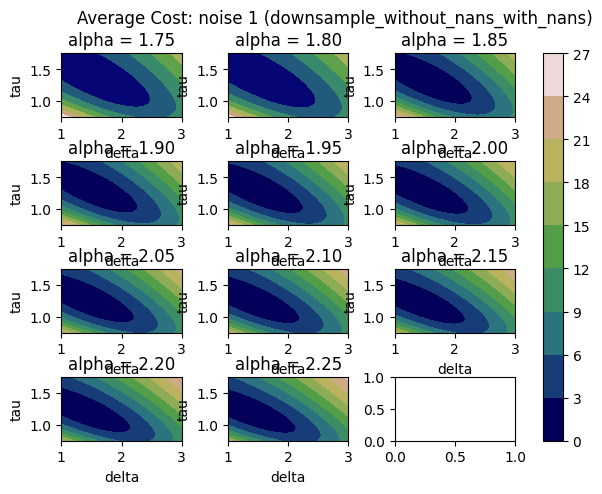

Minimal Cost for Average Cost: noise 2 (downsample_without_nans_with_nans) = 3.9734882258097146; at
      delta   tau  alpha
4851    1.5  1.25    2.0


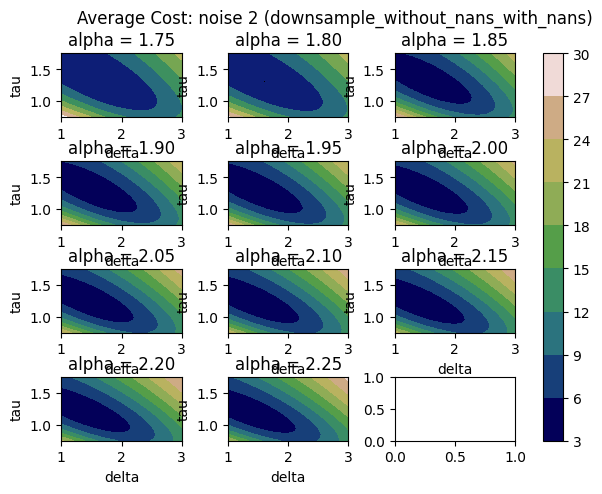

Minimal Cost for Average Cost: noise 3 (downsample_without_nans_with_nans) = 9.004523307531333; at
      delta   tau  alpha
4851    1.5  1.25    2.0


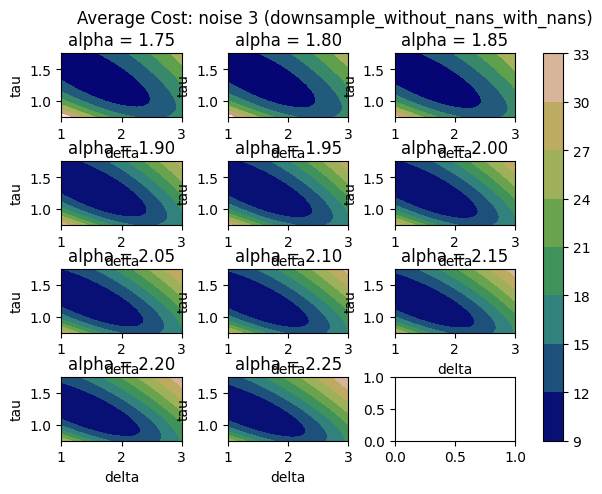

Minimal Cost for Average Cost: noise 4 (downsample_without_nans_with_nans) = 16.05019965846317; at
      delta   tau  alpha
4851    1.5  1.25    2.0


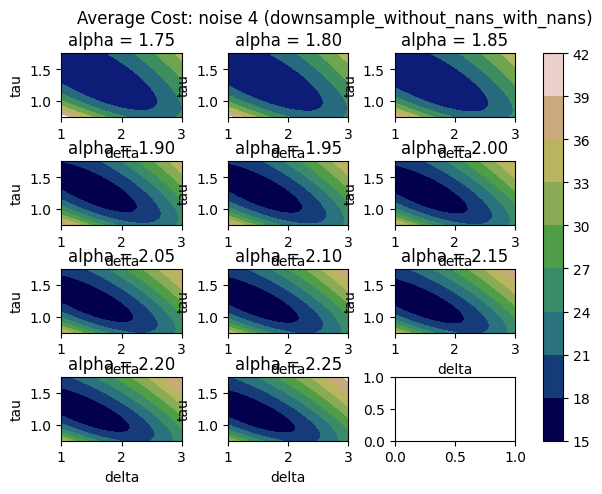

Minimal Cost for Average Cost: noise 5 (downsample_without_nans_with_nans) = 24.729793987279425; at
      delta   tau  alpha
4851    1.5  1.25    2.0


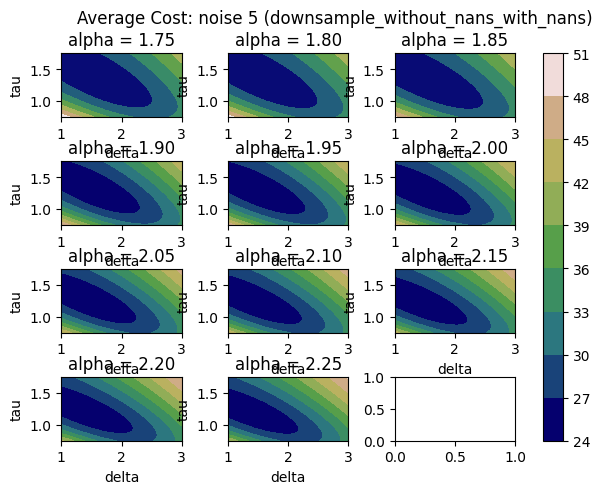

Minimal Cost for Average Cost: noise 6 (downsample_without_nans_with_nans) = 36.19172718896622; at
      delta   tau  alpha
4851    1.5  1.25    2.0


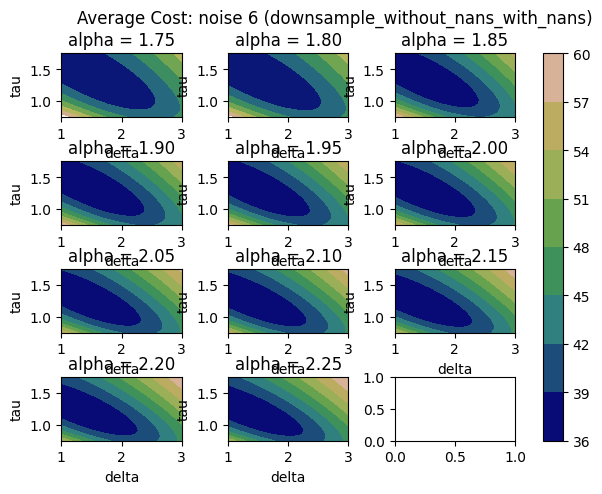

Minimal Cost for Average Cost: noise 7 (downsample_without_nans_with_nans) = 48.75879892100527; at
      delta   tau  alpha
4851    1.5  1.25    2.0


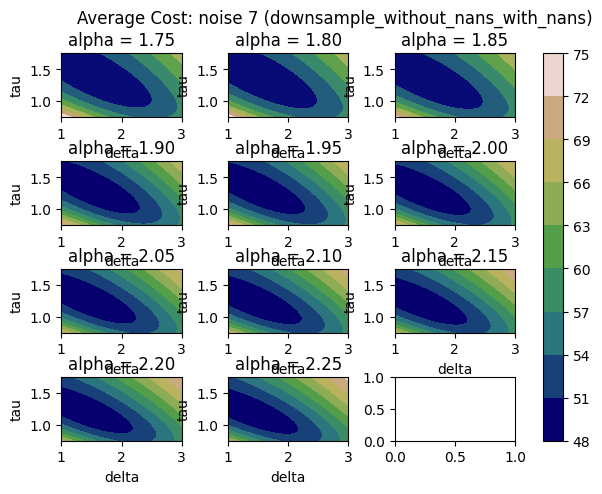

Minimal Cost for Average Cost: noise 8 (downsample_without_nans_with_nans) = 63.476052746730105; at
      delta  tau  alpha
5329   1.55  1.3   1.85


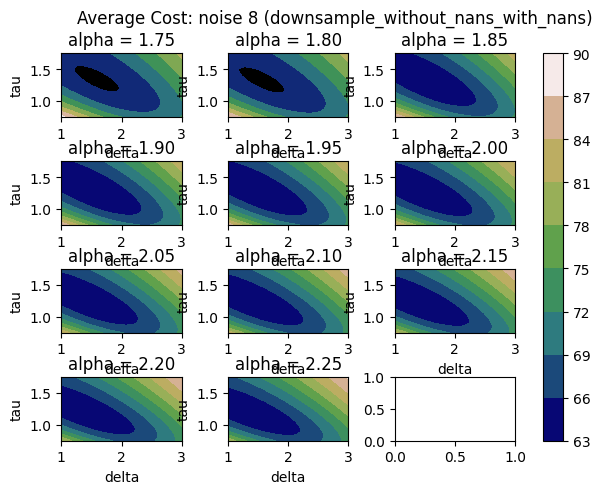

Minimal Cost for Average Cost: noise 9 (downsample_without_nans_with_nans) = 81.28032037359807; at
      delta   tau  alpha
5809    1.6  1.35   1.75


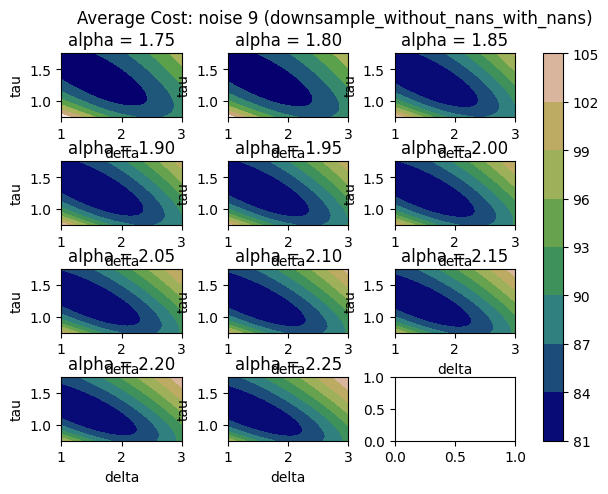

Minimal Cost for Average Cost: noise 10 (downsample_without_nans_with_nans) = 98.6709467795184; at
      delta  tau  alpha
3913    1.4  1.2    2.2


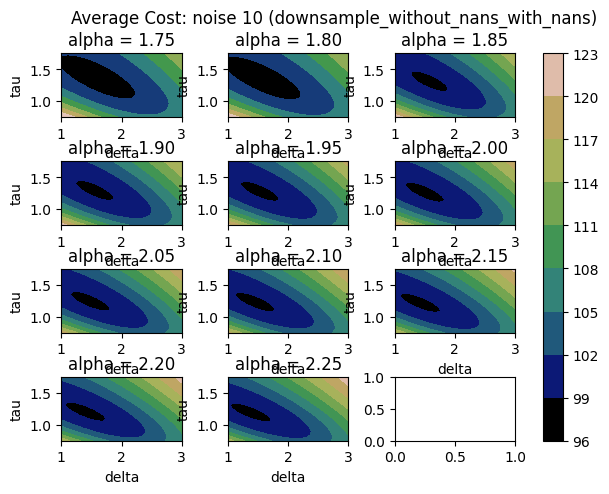

In [32]:
model_name = 'downsample_without_nans_with_nans'
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]

    average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]
    average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
    plot_all_search_results_2d(average_df, separate_by='alpha')


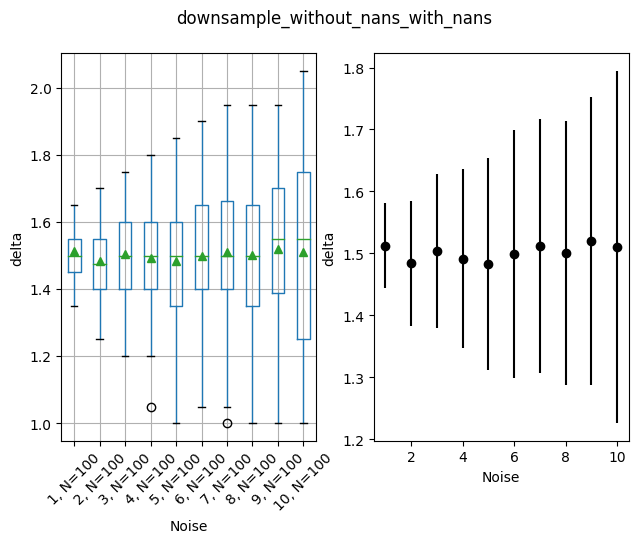

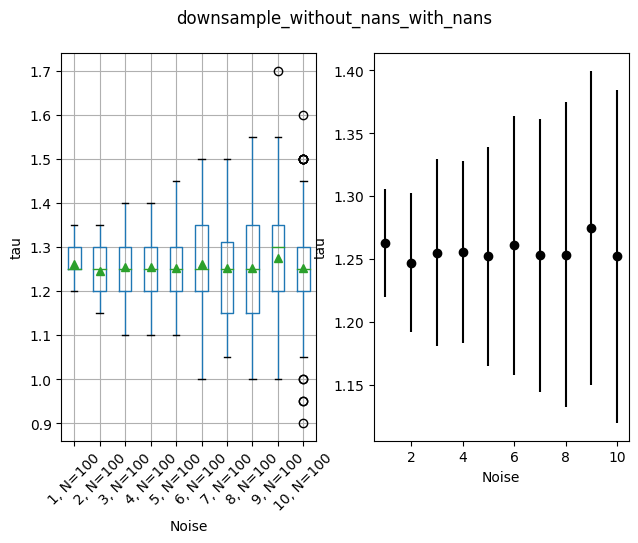

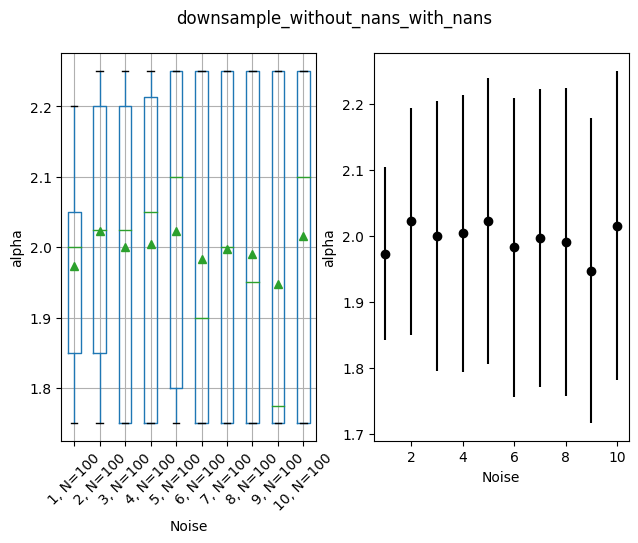

In [33]:
data = []
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]
    minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
    minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()
    
    for point in zip(*np.where(~np.isnan(minimum_cost_array))):
        row_of_interest = df_to_plot.iloc[point[0]]
        data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha'], noise])

chosen_points = pd.DataFrame(data, columns=['delta', 'tau', 'alpha', 'noise']).groupby('noise')

for variable in ['delta', 'tau', 'alpha']:
    fig, axs = plt.subplots(1, 2)
    fig.suptitle(model_name)
    fig.tight_layout()
    axs[0].set_ylabel(variable)
    axs[0].set_xlabel('Noise')
    axs[0] = chosen_points.boxplot(subplots=False, column=variable, rot=45, ax=axs[0], showmeans=True)
    axs[1].set_ylabel(variable)
    axs[1].set_xlabel('Noise')
    axs[1].errorbar(noise_range, chosen_points.mean()[variable], chosen_points.std()[variable], fmt='ok')
    labels = chosen_points.count()
    labels = [f'{noise}, N={n[0].item()}' for noise, n in zip(labels.index, labels.values)]
    plt.setp(axs[0], xticklabels=labels)
    plt.show()

## Local Minima Analysis

### Downsample without missing data

In [34]:
model = df['model_name'].unique()[0]
print(f"For Model '{model}'")
portion_df = df[df['model_name'] == model].drop(columns='model_name')
delta_unique_values = portion_df['delta'].unique()    
tau_unique_values = portion_df['tau'].unique()
alpha_unique_values = portion_df['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(portion_df['delta'].values, new_shape)
tau_pts = np.reshape(portion_df['tau'].values, new_shape)
alpha_pts = np.reshape(portion_df['alpha'].values, new_shape)

For Model 'downsample_without_nans_without_nans'


In [35]:
# Find local minima
columns = portion_df.columns.drop(['delta', 'tau', 'alpha'])
     
m = np.reshape(
    portion_df[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

In [36]:
local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
for noise in noise_range:
    columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
    local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
    for point in local_minima_with_given_noise:
        point_as_list = tuple(point.tolist())
        local_minima.append({
            'noise': noise,
            'iteration': columns[point[-1]].split('trial')[-1],
            'cost': m[point_as_list],
            'delta': delta_pts[point_as_list[:-1]],
            'tau': tau_pts[point_as_list[:-1]],
            'alpha': alpha_pts[point_as_list[:-1]]
        })

local_minima_by_noise = pd.DataFrame(local_minima)
local_minima_by_noise


noise iteration        cost               delta                 tau  \
0         1        75    0.942066  1.3500000000000003  1.2000000000000004   
1         1        83    1.060518  1.3500000000000003  1.2000000000000004   
2         1        34    1.017746  1.3500000000000003  1.2000000000000004   
3         1        69    1.035365  1.3500000000000003  1.2000000000000004   
4         1        99    0.996559  1.3500000000000003  1.2000000000000004   
...     ...       ...         ...                 ...                 ...   
2662     10        94  102.175189  1.9500000000000008  1.3000000000000005   
2663     10         5  102.548371   2.000000000000001  1.0000000000000002   
2664     10         8   92.551032   2.000000000000001  1.2000000000000004   
2665     10        58   87.233910  2.0500000000000007  0.8500000000000001   
2666     10        58   87.236088  2.0500000000000007  0.9000000000000001   

                   alpha  
0                    2.2  
1                    2.2  
2     2.2500000000000004  
3     2.2500000000000004  
4     2.2500000000000004  
...                  ...  
2662                1.75  
2663  2.2500000000000004  
2664                1.75  
2665  2.2500000000000004  
2666  2.1500000000000004  

[2667 rows x 6 columns]

In [37]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').describe()

Number of Local Minima                                          
                       count  mean       std  min  25%  50%   75%  max
noise                                                                 
1                      100.0  3.48  0.540856  2.0  3.0  3.5  4.00  4.0
2                      100.0  3.34  0.669992  1.0  3.0  3.0  4.00  4.0
3                      100.0  3.18  0.770412  1.0  3.0  3.0  4.00  4.0
4                      100.0  2.79  0.956583  1.0  2.0  3.0  3.25  4.0
5                      100.0  2.79  0.967085  1.0  2.0  3.0  3.25  4.0
6                      100.0  2.49  1.193374  1.0  1.0  3.0  3.00  5.0
7                      100.0  2.28  1.101697  1.0  1.0  2.0  3.00  4.0
8                      100.0  2.20  1.073087  1.0  1.0  2.0  3.00  4.0
9                      100.0  2.21  1.200126  1.0  1.0  2.0  3.00  5.0
10                     100.0  1.91  1.035677  1.0  1.0  2.0  3.00  4.0

#### Local minima at edges

In [38]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

noise iteration        cost delta                 tau  \
1558      6        29   34.539262   1.0  1.3500000000000005   
1807      7        46   47.553579   1.0  1.3000000000000005   
1808      7        14   48.413934   1.0  1.3500000000000005   
1809      7         2   49.527891   1.0  1.3500000000000005   
1810      7        55   48.517534   1.0  1.4000000000000006   
2035      8        67   67.815144   1.0  1.2500000000000004   
2036      8        29   68.577158   1.0  1.3500000000000005   
2037      8         8   66.675971   1.0  1.3500000000000005   
2255      9        74   77.565551   1.0  1.3500000000000005   
2256      9        74   77.554702   1.0  1.4000000000000006   
2257      9        54   79.052463   1.0  1.4000000000000006   
2258      9        74   77.559536   1.0  1.4500000000000006   
2259      9        54   79.047536   1.0  1.4500000000000006   
2260      9        43   84.155380   1.0  1.4500000000000006   
2261      9        54   79.054993   1.0  1.5000000000000007   
2262      9        95   76.630994   1.0  1.5000000000000007   
2263      9        95   76.625841   1.0  1.5500000000000007   
2476     10        11   99.427622   1.0  1.2500000000000004   
2477     10        43  101.140468   1.0  1.2500000000000004   
2478     10        39   98.435282   1.0  1.3000000000000005   
2479     10        39   98.430147   1.0  1.3500000000000005   
2480     10         0  105.061308   1.0  1.3500000000000005   
2481     10        86  101.906715   1.0  1.3500000000000005   
2482     10         0  105.066297   1.0  1.4000000000000006   
2483     10        29   91.478830   1.0  1.4000000000000006   

                   alpha  
1558  2.2500000000000004  
1807  2.2500000000000004  
1808  2.1000000000000005  
1809  2.2500000000000004  
1810  2.2500000000000004  
2035  2.2500000000000004  
2036                 2.2  
2037  2.2500000000000004  
2255                 2.2  
2256  2.1000000000000005  
2257                 2.2  
2258                 2.0  
2259  2.1000000000000005  
2260                 2.2  
2261                 2.0  
2262                 2.0  
2263  1.9000000000000001  
2476                 2.2  
2477                 2.2  
2478  2.2500000000000004  
2479  2.1500000000000004  
2480                 2.2  
2481  2.2500000000000004  
2482  2.1000000000000005  
2483  2.1500000000000004

In [39]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [40]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [41]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [42]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

noise iteration        cost               delta                 tau  \
296       1         0    1.088966  1.6000000000000005  1.3500000000000005   
297       1         1    0.937036  1.6000000000000005  1.3500000000000005   
298       1         2    1.065966  1.6000000000000005  1.3500000000000005   
299       1         6    0.955426  1.6000000000000005  1.3500000000000005   
300       1         7    0.952831  1.6000000000000005  1.3500000000000005   
...     ...       ...         ...                 ...                 ...   
2658     10        38  106.749581  1.9000000000000008  1.2000000000000004   
2659     10        67   91.405184  1.9000000000000008  1.3500000000000005   
2661     10        71   99.187509  1.9500000000000008  1.2000000000000004   
2662     10        94  102.175189  1.9500000000000008  1.3000000000000005   
2664     10         8   92.551032   2.000000000000001  1.2000000000000004   

     alpha  
296   1.75  
297   1.75  
298   1.75  
299   1.75  
300   1.75  
...    ...  
2658  1.75  
2659  1.75  
2661  1.75  
2662  1.75  
2664  1.75  

[398 rows x 6 columns]

In [43]:
alpha_min.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1        47      2  1.6000000000000005   45    47      2  1.3500000000000005   
10       40     16  1.7000000000000006    6    40      9  1.3500000000000005   
2        30      5  1.6000000000000005   12    30      3  1.3500000000000005   
3        37      6  1.6000000000000005   10    37      4  1.3500000000000005   
4        33      7  1.6500000000000006   10    33      3  1.3500000000000005   
5        36      9  1.6000000000000005   11    36      4  1.3500000000000005   
6        47     10  1.6000000000000005    8    47      7  1.3500000000000005   
7        33     10  1.5500000000000005    8    33      6  1.3000000000000005   
8        40     13  1.6500000000000006    8    40      7  1.3000000000000005   
9        55     15  1.7000000000000006    8    55      8  1.3500000000000005   

            
      freq  
noise       
1       46  
10       8  
2       23  
3       18  
4       17  
5       15  
6       15  
7       10  
8       13  
9       16

In [44]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

noise iteration        cost               delta                 tau  \
2         1        34    1.017746  1.3500000000000003  1.2000000000000004   
3         1        69    1.035365  1.3500000000000003  1.2000000000000004   
4         1        99    0.996559  1.3500000000000003  1.2000000000000004   
5         1        61    0.963302  1.4000000000000004  1.1500000000000004   
67        1        10    0.930726  1.4500000000000004  1.1500000000000004   
...     ...       ...         ...                 ...                 ...   
2618     10        78  103.135706  1.7000000000000006  1.1000000000000003   
2619     10        94  102.178386  1.7000000000000006  1.1500000000000004   
2630     10        75   91.935204  1.7500000000000007  1.0000000000000002   
2663     10         5  102.548371   2.000000000000001  1.0000000000000002   
2665     10        58   87.233910  2.0500000000000007  0.8500000000000001   

                   alpha  
2     2.2500000000000004  
3     2.2500000000000004  
4     2.2500000000000004  
5     2.2500000000000004  
67    2.2500000000000004  
...                  ...  
2618  2.2500000000000004  
2619  2.2500000000000004  
2630  2.2500000000000004  
2663  2.2500000000000004  
2665  2.2500000000000004  

[379 rows x 6 columns]

In [45]:
alpha_max.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1         7      3  1.3500000000000003    3     7      2  1.1500000000000004   
10       54     17  1.2500000000000002    8    54     11  1.2000000000000004   
2        37      4  1.3500000000000003   16    37      2  1.2000000000000004   
3        36      6  1.4500000000000004   14    36      4  1.1500000000000004   
4        42      8  1.4000000000000004   15    42      4  1.1500000000000004   
5        44     11  1.3500000000000003   10    44      6  1.1500000000000004   
6        40     12  1.3500000000000003    8    40      7  1.2000000000000004   
7        42     13  1.4000000000000004    6    42      8  1.1500000000000004   
8        42     13  1.5500000000000005    8    42      7  1.1500000000000004   
9        35     14  1.3000000000000003    6    35      7  1.2000000000000004   

            
      freq  
noise       
1        4  
10      11  
2       21  
3       23  
4       20  
5       16  
6       13  
7       11  
8       11  
9       10

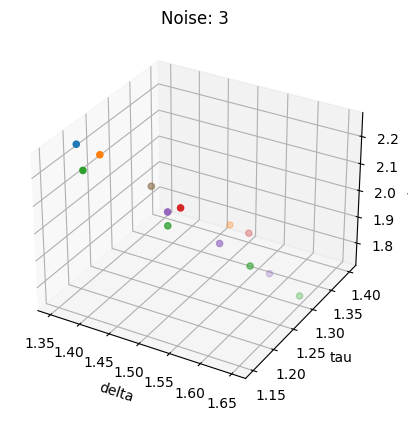

In [46]:
noise = 3
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

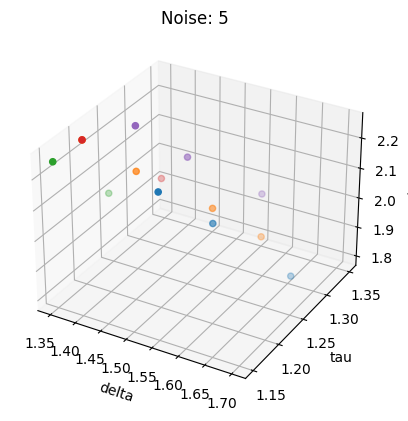

In [47]:
noise = 5
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

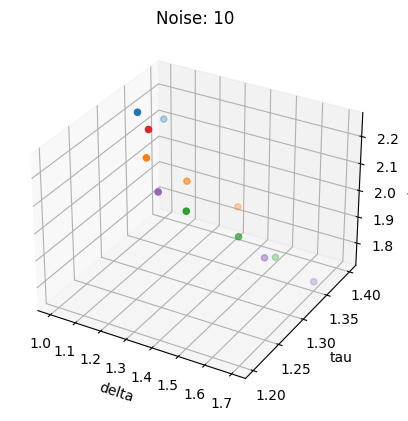

In [48]:
noise = 10
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

### Downsample with missing data

In [49]:
model = df['model_name'].unique()[1]
print(f"For Model '{model}'")
portion_df = df[df['model_name'] == model].drop(columns='model_name')
delta_unique_values = portion_df['delta'].unique()    
tau_unique_values = portion_df['tau'].unique()
alpha_unique_values = portion_df['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(portion_df['delta'].values, new_shape)
tau_pts = np.reshape(portion_df['tau'].values, new_shape)
alpha_pts = np.reshape(portion_df['alpha'].values, new_shape)

For Model 'downsample_without_nans_with_nans'


In [50]:
# Find local minima
columns = portion_df.columns.drop(['delta', 'tau', 'alpha'])
     
m = np.reshape(
    portion_df[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

In [51]:
local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
for noise in noise_range:
    columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
    local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
    for point in local_minima_with_given_noise:
        point_as_list = tuple(point.tolist())
        local_minima.append({
            'noise': noise,
            'iteration': columns[point[-1]].split('trial')[-1],
            'cost': m[point_as_list],
            'delta': delta_pts[point_as_list[:-1]],
            'tau': tau_pts[point_as_list[:-1]],
            'alpha': alpha_pts[point_as_list[:-1]]
        })

local_minima_by_noise = pd.DataFrame(local_minima)
local_minima_by_noise


noise iteration        cost               delta                 tau  \
0         1        17    0.870065  1.3500000000000003  1.2000000000000004   
1         1        37    0.956730  1.3500000000000003  1.2000000000000004   
2         1        56    1.115240  1.3500000000000003  1.2000000000000004   
3         1        83    1.040250  1.3500000000000003  1.2000000000000004   
4         1         2    1.026330  1.3500000000000003  1.2000000000000004   
...     ...       ...         ...                 ...                 ...   
2518     10        58   83.611459   2.000000000000001  1.0500000000000003   
2519     10        33  107.556073   2.000000000000001  1.2000000000000004   
2520     10         5  103.839423  2.0500000000000007  0.9500000000000002   
2521     10        71   95.743237  2.0500000000000007  1.2000000000000004   
2522     10         5  103.841495   2.200000000000001  0.9000000000000001   

                   alpha  
0                    2.2  
1                    2.2  
2                    2.2  
3                    2.2  
4     2.2500000000000004  
...                  ...  
2518  1.9000000000000001  
2519                1.85  
2520  2.2500000000000004  
2521                1.75  
2522  2.2500000000000004  

[2523 rows x 6 columns]

In [52]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').describe()

Number of Local Minima                                         
                       count  mean       std  min  25%  50%  75%  max
noise                                                                
1                      100.0  3.44  0.498888  3.0  3.0  3.0  4.0  4.0
2                      100.0  3.29  0.671121  1.0  3.0  3.0  4.0  4.0
3                      100.0  3.01  0.834787  1.0  3.0  3.0  4.0  4.0
4                      100.0  2.73  1.062254  1.0  2.0  3.0  4.0  4.0
5                      100.0  2.40  1.100964  1.0  1.0  3.0  3.0  4.0
6                      100.0  2.22  1.133333  1.0  1.0  2.0  3.0  4.0
7                      100.0  2.20  1.163415  1.0  1.0  2.0  3.0  5.0
8                      100.0  2.01  1.193374  1.0  1.0  2.0  3.0  6.0
9                      100.0  2.06  1.144332  1.0  1.0  2.0  3.0  4.0
10                     100.0  1.87  1.060351  1.0  1.0  1.0  3.0  4.0

#### Local minima at edges

In [53]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

noise iteration        cost delta                 tau  \
1247      5        66   25.717554   1.0  1.3000000000000005   
1709      7         2   48.266301   1.0  1.4000000000000006   
1710      7         2   48.261819   1.0  1.4500000000000006   
1929      8        29   70.017520   1.0  1.4000000000000006   
2130      9        45   96.538360   1.0  1.2500000000000004   
2131      9        54   82.791953   1.0  1.4000000000000006   
2132      9        95   76.403253   1.0  1.5500000000000007   
2336     10        11  100.531402   1.0  1.2000000000000004   
2337     10        43  100.330079   1.0  1.2500000000000004   
2338     10        31  101.096802   1.0  1.3000000000000005   
2339     10        39   97.885785   1.0  1.3000000000000005   
2340     10        31  101.096387   1.0  1.3500000000000005   
2341     10        29   91.466911   1.0  1.3500000000000005   
2342     10        31  101.107311   1.0  1.4000000000000006   
2343     10         3   94.495917   1.0  1.4000000000000006   

                   alpha  
1247  2.2500000000000004  
1709                 2.2  
1710  2.1000000000000005  
1929  2.0500000000000003  
2130  2.2500000000000004  
2131  2.2500000000000004  
2132  1.9000000000000001  
2336  2.2500000000000004  
2337  2.2500000000000004  
2338  2.2500000000000004  
2339  2.2500000000000004  
2340  2.1500000000000004  
2341                 2.2  
2342  2.0500000000000003  
2343  2.2500000000000004

In [54]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [55]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [56]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [57]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

noise iteration        cost               delta                 tau  \
264       1        83    1.041487  1.5500000000000005  1.3500000000000005   
300       1         1    0.894445  1.6000000000000005  1.3500000000000005   
301       1         6    0.946526  1.6000000000000005  1.3500000000000005   
302       1         7    0.935750  1.6000000000000005  1.3500000000000005   
303       1         8    0.861419  1.6000000000000005  1.3500000000000005   
...     ...       ...         ...                 ...                 ...   
2511     10        51  111.448353  1.9000000000000008  1.1500000000000004   
2513     10        54   97.797164  1.9000000000000008  1.2500000000000004   
2515     10        38  103.111890  1.9500000000000008  1.1000000000000003   
2517     10        94  104.142070  1.9500000000000008  1.3000000000000005   
2521     10        71   95.743237  2.0500000000000007  1.2000000000000004   

     alpha  
264   1.75  
300   1.75  
301   1.75  
302   1.75  
303   1.75  
...    ...  
2511  1.75  
2513  1.75  
2515  1.75  
2517  1.75  
2521  1.75  

[417 rows x 6 columns]

In [58]:
alpha_min.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1        39      4  1.6000000000000005   36    39      2  1.3500000000000005   
10       43     18  1.7000000000000006    5    43     10  1.3000000000000005   
2        34      5  1.6000000000000005   12    34      2  1.3500000000000005   
3        38      6  1.6500000000000006   12    38      4  1.3500000000000005   
4        38      7  1.6000000000000005   13    38      4  1.3500000000000005   
5        31     11  1.6000000000000005    8    31      5  1.3500000000000005   
6        46     12  1.6500000000000006    7    46      8  1.3000000000000005   
7        42     12  1.8000000000000007   11    42      8  1.3000000000000005   
8        48     16  1.6000000000000005    7    48      9  1.3000000000000005   
9        58     15  1.5000000000000004    8    58     10  1.3500000000000005   

            
      freq  
noise       
1       38  
10       9  
2       25  
3       22  
4       18  
5       10  
6       10  
7        9  
8       11  
9       17

In [59]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

noise iteration        cost               delta                 tau  \
4         1         2    1.026330  1.3500000000000003  1.2000000000000004   
5         1        30    0.951190  1.3500000000000003  1.2000000000000004   
6         1        34    0.999060  1.3500000000000003  1.2000000000000004   
7         1        52    1.017678  1.3500000000000003  1.2000000000000004   
8         1        57    1.045127  1.3500000000000003  1.2000000000000004   
...     ...       ...         ...                 ...                 ...   
2508     10        58   83.540198  1.9000000000000008  0.9500000000000002   
2509     10        27  100.952842  1.9000000000000008  1.0000000000000002   
2514     10        75   91.294742  1.9500000000000008  0.9000000000000001   
2520     10         5  103.839423  2.0500000000000007  0.9500000000000002   
2522     10         5  103.841495   2.200000000000001  0.9000000000000001   

                   alpha  
4     2.2500000000000004  
5     2.2500000000000004  
6     2.2500000000000004  
7     2.2500000000000004  
8     2.2500000000000004  
...                  ...  
2508  2.2500000000000004  
2509  2.2500000000000004  
2514  2.2500000000000004  
2520  2.2500000000000004  
2522  2.2500000000000004  

[421 rows x 6 columns]

In [60]:
alpha_max.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1        14      3  1.3500000000000003    8    14      2  1.2000000000000004   
10       60     22                 1.0    5    60     11  1.2500000000000004   
2        34      5  1.4000000000000004   12    34      3  1.1500000000000004   
3        43      7  1.4500000000000004   11    43      4  1.1500000000000004   
4        41     10  1.4000000000000004    9    41      5  1.1500000000000004   
5        44     13  1.3500000000000003   11    44      6  1.2000000000000004   
6        48     15  1.4000000000000004   10    48      9  1.2000000000000004   
7        38     12  1.2000000000000002    6    38      7  1.1000000000000003   
8        54     14  1.2000000000000002    7    54      9  1.1500000000000004   
9        45     15  1.2000000000000002    6    45      9  1.1500000000000004   

            
      freq  
noise       
1        9  
10      12  
2       17  
3       20  
4       18  
5       19  
6       20  
7       13  
8       14  
9       11

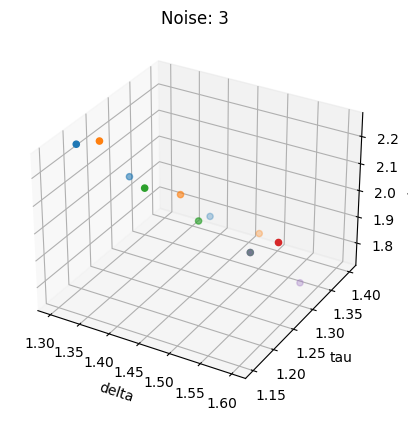

In [61]:
noise = 3
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

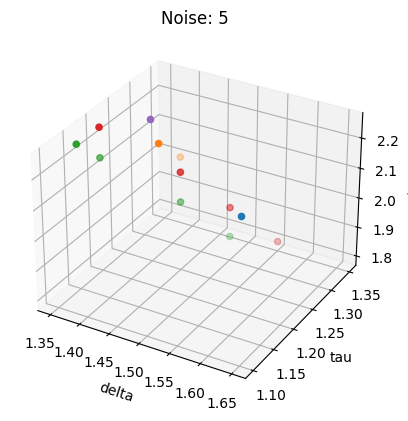

In [62]:
noise = 5
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

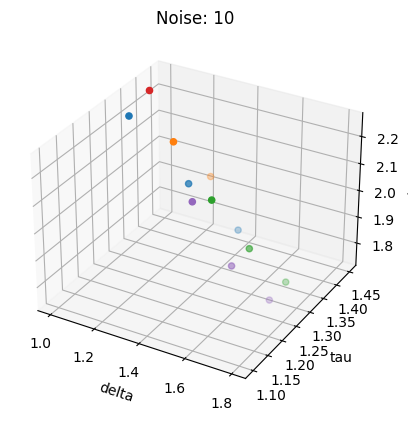

In [63]:
noise = 10
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()